# Hybrid text-and-metadata model

This notebook blends the strongest baseline from **`baseline_text_models.ipynb`**  
(title TF-IDF + Logistic Regression) with the engineered metadata columns that
were used in **`etenders.ipynb`**.

* 5-fold stratified cross-validation for a fair comparison  
* Calibrated probabilities so every model exposes `predict_proba`  
* Automatic threshold search to hit a configurable recall target

In [13]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.calibration import CalibratedClassifierCV

# project helper
from prepare_data import load_clean_dataframe  # type: ignore


def threshold_for_recall(scores, y_true, recall_target=0.85):
    """Return the highest threshold that still achieves recall ≥ target."""
    prec, rec, thr = precision_recall_curve(y_true, scores)
    candidates = [t for r, t in zip(rec[:-1], thr) if r >= recall_target]
    return max(candidates) if candidates else thr.min()

In [14]:
df = load_clean_dataframe(labelled_only=True)

# Minimal examples of the extra features from *etenders.ipynb*
df["title_len"] = df["title"].str.len()
df["contains_date"] = df["title"].str.contains(r"\b20\d{2}\b", regex=True).astype(int)
# ➜ add more flags / numeric columns here to match the full notebook

df["has_pdf"] = df["pdf_url"].notna() & df["pdf_url"].str.strip().ne("")
df["has_pdf"] = df["has_pdf"].astype(int)

text_col = "title"
cat_cols = ["ca", "procedure"]
num_cols = ["has_pdf"]

y = df["bid"].astype(int).values
X = df.drop(columns=["bid"])

/mnt/c/Users/rober/GitHub/module_2/python/prepare_data.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ca"].fillna("", inplace=True)
/mnt/c/Users/rober/GitHub/module_2/python/prepare_data.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

In [15]:
preprocess = ColumnTransformer(
    transformers=[
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 2),
                min_df=3,
                max_features=40_000,
                strip_accents="unicode",
                lowercase=True,
            ),
            text_col,
        ),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ]
)

base_clf = LogisticRegression(
    max_iter=400,
    class_weight="balanced",
    solver="lbfgs",
    n_jobs=-1,
)

pipe = Pipeline([("prep", preprocess), ("clf", base_clf)])
calibrated = CalibratedClassifierCV(pipe, cv=3, method="sigmoid")

Chosen threshold to hit recall ≥0.85  →  0.049
              precision    recall  f1-score   support

           0      0.985     0.695     0.815      1955
           1      0.166     0.856     0.278       139

    accuracy                          0.705      2094
   macro avg      0.576     0.775     0.547      2094
weighted avg      0.931     0.705     0.779      2094



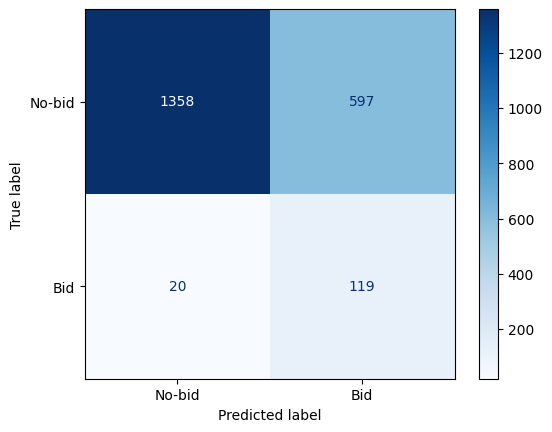

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

proba = cross_val_predict(
    calibrated, X, y, cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]

thr = threshold_for_recall(proba, y, recall_target=0.85)
print(f"Chosen threshold to hit recall ≥0.85  →  {thr:.3f}")

y_pred = (proba >= thr).astype(int)

print(classification_report(y, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(
    y, y_pred, display_labels=["No-bid", "Bid"], cmap="Blues"
)
plt.show()

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

calibrated.fit(X_train, y_train)          # 1️⃣ train once
proba = calibrated.predict_proba(X_test)[:, 1]   # 2️⃣ scores for *test* only

chosen threshold (training) = 0.299
recall (test) = 0.25


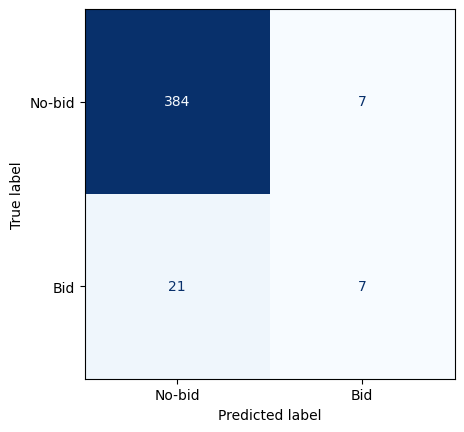

In [18]:
from sklearn.metrics import recall_score, ConfusionMatrixDisplay

# ──────────────────────────────────────────────
# 1️⃣  decide threshold on TRAINING data only
# ──────────────────────────────────────────────
proba_train = calibrated.predict_proba(X_train)[:, 1]
thr = threshold_for_recall(proba_train, y_train, recall_target=0.90)
print(f"chosen threshold (training) = {thr:0.3f}")

# ──────────────────────────────────────────────
# 2️⃣  evaluate that threshold on TEST set
# ──────────────────────────────────────────────
proba_test = calibrated.predict_proba(X_test)[:, 1]
y_pred = (proba_test >= thr).astype(int)

print("recall (test) =", recall_score(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["No-bid", "Bid"],
    cmap="Blues", colorbar=False
)

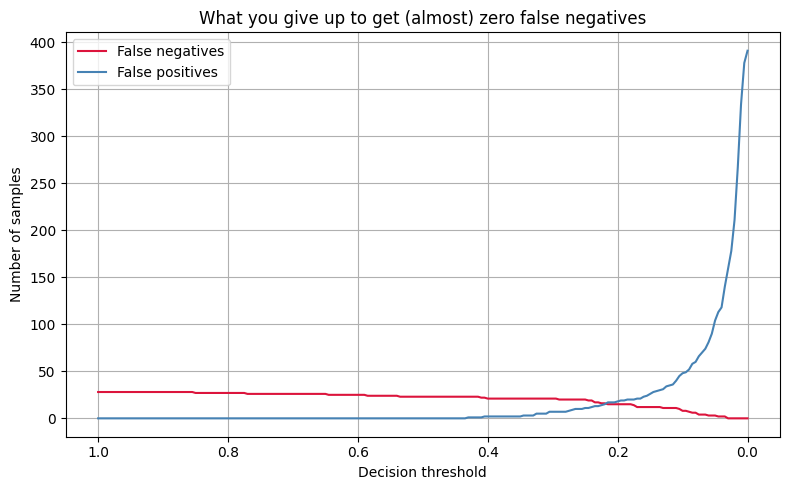

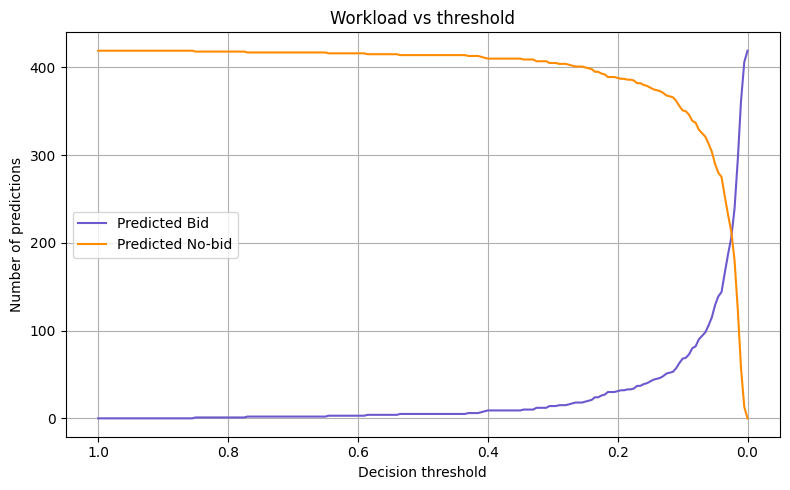

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# 1.  Scan thresholds and collect FN / FP counts
# ------------------------------------------------------------------
thresholds = np.linspace(0.0, 1.0, 201)        # 0.00, 0.005, …, 1.00
records = []

for thr in thresholds:
    y_pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    records.append(
        {
            "thr": thr,
            "false_neg": fn,
            "false_pos": fp,
            "pred_bid": tp + fp,     # how many rows you must review
            "pred_no_bid": tn + fn,
        }
    )

stats = pd.DataFrame(records)

# ------------------------------------------------------------------
# 2.  Plot FN vs FP — makes the trade-off jump out
# ------------------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.lineplot(data=stats, x="thr", y="false_neg", label="False negatives", color="crimson")
sns.lineplot(data=stats, x="thr", y="false_pos", label="False positives", color="steelblue")

plt.gca().invert_xaxis()              # high threshold on the left (optional)
plt.xlabel("Decision threshold")
plt.ylabel("Number of samples")
plt.title("What you give up to get (almost) zero false negatives")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 3.  (Optional) show how many titles land in each bucket
# ------------------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.lineplot(data=stats, x="thr", y="pred_bid",    label="Predicted Bid",    color="slateblue")
sns.lineplot(data=stats, x="thr", y="pred_no_bid", label="Predicted No-bid", color="darkorange")

plt.gca().invert_xaxis()
plt.xlabel("Decision threshold")
plt.ylabel("Number of predictions")
plt.title("Workload vs threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Best threshold (FN ≈ FP) : 0.220
→ False-negatives (missed bids) : 16
→ False-positives (extra reviews): 15
   Total tenders to review       : 27


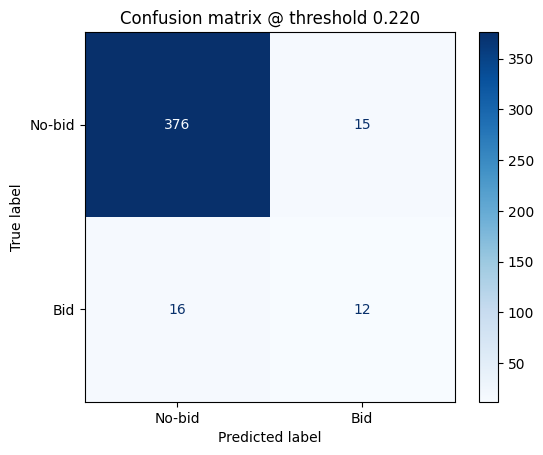

In [20]:
# ------------------------------------------------------------------
# 4.  Pick the threshold where FN ≈ FP  (intersection of the curves)
# ------------------------------------------------------------------
stats["gap"] = (stats["false_neg"] - stats["false_pos"]).abs()
best = stats.loc[stats["gap"].idxmin()]        # smallest distance

thr_opt = best["thr"]
fn_opt  = int(best["false_neg"])
fp_opt  = int(best["false_pos"])

print(f"Best threshold (FN ≈ FP) : {thr_opt:0.3f}")
print(f"→ False-negatives (missed bids) : {fn_opt}")
print(f"→ False-positives (extra reviews): {fp_opt}")
print(f"   Total tenders to review       : {best['pred_bid']:.0f}")

# Optional sanity-check – confusion matrix at that threshold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred_opt = (proba >= thr_opt).astype(int)
cm = confusion_matrix(y_test, y_pred_opt, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No-bid", "Bid"]
)
disp.plot(values_format="d", cmap="Blues")
plt.title(f"Confusion matrix @ threshold {thr_opt:0.3f}")
plt.show()

Now, this is without weighting anything. We can say purely from looking at the threshold where the lines cross that with a threshold of 0.22 we get the optimal number of bids, False Negatives and False positives BUT this doesn't take into account the over-whelming cost of False Negatives.

Best threshold (FN ≈ FP) : 0.060
→ False-negatives (missed bids) : 3
→ False-positives (extra reviews): 81
   Total tenders to review       : 106


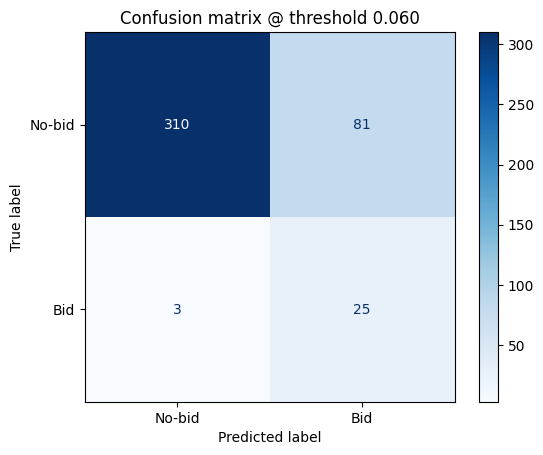

In [21]:
# ------------------------------------------------------------------
# 5.  Apply a COST to false negative vs. false positives
# ------------------------------------------------------------------
stats["cost"] = 25 * stats["false_neg"] + 1 * stats["false_pos"]
best = stats.loc[stats["cost"].idxmin()]

thr_opt = best["thr"]
fn_opt  = int(best["false_neg"])
fp_opt  = int(best["false_pos"])

print(f"Best threshold (FN ≈ FP) : {thr_opt:0.3f}")
print(f"→ False-negatives (missed bids) : {fn_opt}")
print(f"→ False-positives (extra reviews): {fp_opt}")
print(f"   Total tenders to review       : {best['pred_bid']:.0f}")

# Optional sanity-check – confusion matrix at that threshold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred_opt = (proba >= thr_opt).astype(int)
cm = confusion_matrix(y_test, y_pred_opt, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No-bid", "Bid"]
)
disp.plot(values_format="d", cmap="Blues")
plt.title(f"Confusion matrix @ threshold {thr_opt:0.3f}")
plt.show()

Now, this is _better_ however, we're still reviewing 81 false positives which overall is an 80% workload reduction but we've still got 3 false negatives. Maybe we still need to find a better solution.


optimal threshold (FN ≈ FP) : 0.220
 → False-negatives : 16
 → False-positives : 15


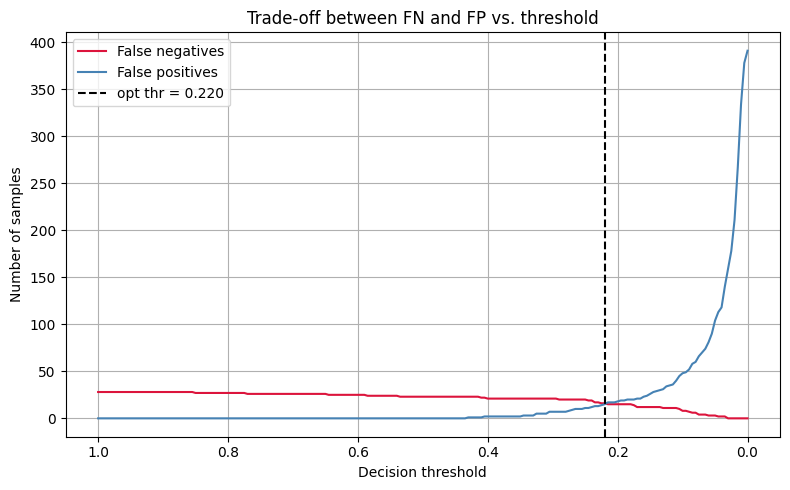

In [24]:
# ------------------------------------------------------------------
#  Locate the FN ≈ FP crossing point and visualise it
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# 1. find threshold where FN and FP are closest
stats["gap"] = (stats["false_neg"] - stats["false_pos"]).abs()
best       = stats.loc[stats["gap"].idxmin()]
thr_opt    = best["thr"]
fn_opt     = int(best["false_neg"])
fp_opt     = int(best["false_pos"])

print(f"optimal threshold (FN ≈ FP) : {thr_opt:0.3f}")
print(f" → False-negatives : {fn_opt}")
print(f" → False-positives : {fp_opt}")

# 2. plot the curves *with* the vertical reference line
plt.figure(figsize=(8, 5))
sns.lineplot(data=stats, x="thr", y="false_neg", label="False negatives", color="crimson")
sns.lineplot(data=stats, x="thr", y="false_pos", label="False positives", color="steelblue")

plt.axvline(thr_opt, color="black", ls="--", label=f"opt thr = {thr_opt:0.3f}")
plt.gca().invert_xaxis()          # keep 1.0 on the left (optional)

plt.xlabel("Decision threshold")
plt.ylabel("Number of samples")
plt.title("Trade-off between FN and FP vs. threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

best threshold (25× FN cost) : 0.060
 → False-negatives  : 3
 → False-positives  : 81
 → Total cost       : 156


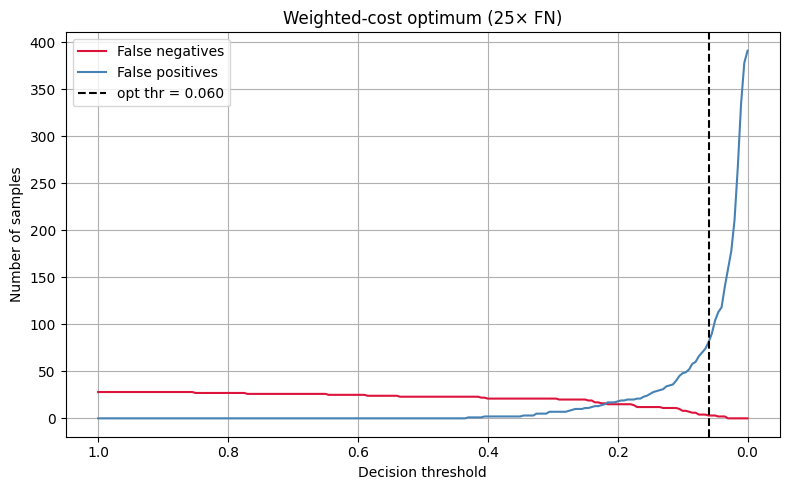

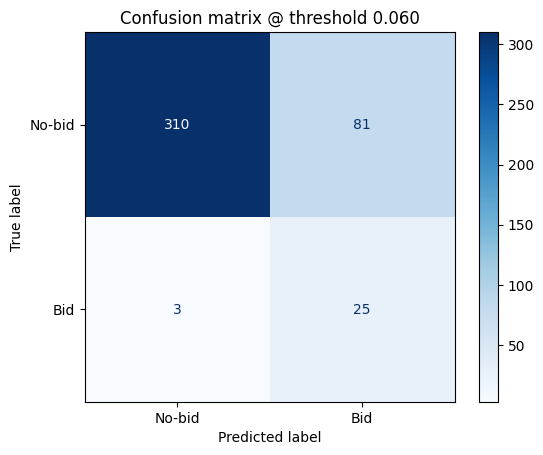

In [25]:
# ------------------------------------------------------------------
#  Threshold search – cost(FN) = 25 × cost(FP)
# ------------------------------------------------------------------
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. compute the weighted cost for every threshold
stats["cost"] = 25 * stats["false_neg"] + 1 * stats["false_pos"]
best_cost     = stats.loc[stats["cost"].idxmin()]

thr_cost = best_cost["thr"]
fn_cost  = int(best_cost["false_neg"])
fp_cost  = int(best_cost["false_pos"])
tot_cost = int(best_cost["cost"])

print(f"best threshold (25× FN cost) : {thr_cost:0.3f}")
print(f" → False-negatives  : {fn_cost}")
print(f" → False-positives  : {fp_cost}")
print(f" → Total cost       : {tot_cost}")

# 2. draw FN / FP curves with the chosen threshold annotated
plt.figure(figsize=(8, 5))
sns.lineplot(data=stats, x="thr", y="false_neg", label="False negatives", color="crimson")
sns.lineplot(data=stats, x="thr", y="false_pos", label="False positives", color="steelblue")
plt.axvline(thr_cost, color="black", ls="--", label=f"opt thr = {thr_cost:0.3f}")

plt.gca().invert_xaxis()
plt.xlabel("Decision threshold")
plt.ylabel("Number of samples")
plt.title("Weighted-cost optimum (25× FN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. sanity-check – confusion matrix at that threshold
y_pred_cost = (proba >= thr_cost).astype(int)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_cost, display_labels=["No-bid", "Bid"], cmap="Blues", values_format="d"
)
plt.title(f"Confusion matrix @ threshold {thr_cost:0.3f}")
plt.show()

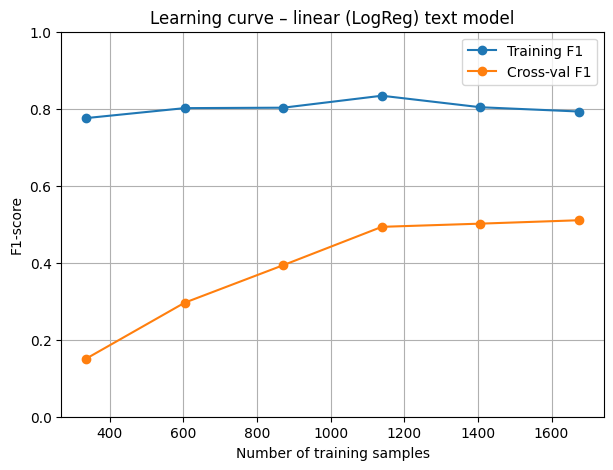

In [27]:
# ─── Learning curve for the linear (Logistic-Regression) model ────────────────
from sklearn.model_selection import learning_curve, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# 1.  Use exactly the same CV object as before so the comparison is fair
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2.  learning_curve returns the mean train / validation scores
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipe,                 # the linear text model (preprocess → LR)
    X=X,
    y=y,
    train_sizes=np.linspace(0.2, 1.0, 6),  # 20 % … 100 % of the data
    cv=cv,
    scoring="f1",                   # keep the same metric as before
    n_jobs=-1,
)

# 3.  Average over the 5 folds
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

# 4.  Plot
plt.figure(figsize=(7, 5))
plt.plot(train_sizes, train_mean, "o-", label="Training F1")
plt.plot(train_sizes, val_mean,   "o-", label="Cross-val F1")
plt.ylim(0, 1)
plt.xlabel("Number of training samples")
plt.ylabel("F1-score")
plt.title("Learning curve – linear (LogReg) text model")
plt.grid(True)
plt.legend()
plt.show()

It'd be useful to be able to visualize how the linear regression model actually works


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Vectorise *titles only* and compress to 2 latent dimensions
viz_pipe = make_pipeline(
    TfidfVectorizer(stop_words="english",
                    ngram_range=(1, 2),
                    min_df=3,
                    max_features=40_000,
                    strip_accents="unicode",
                    lowercase=True),
    TruncatedSVD(n_components=2, random_state=42),
    LogisticRegression(max_iter=400, class_weight="balanced"),
)

# 2. Fit on all labelled rows (nothing leaks – we do this purely to visualise)
X_2d = viz_pipe[:-1].fit_transform(df["title"])   # everything up to (not incl.) LR
y     = df["bid"].to_numpy()
viz_pipe[-1].fit(X_2d, y)                         # fit the tiny logistic

# 3. Store for the next cell
Z      = X_2d          # 2-column array, one point = one tender
y_true = y
clf2d  = viz_pipe[-1]  # the LR sitting at the end of the little pipeline

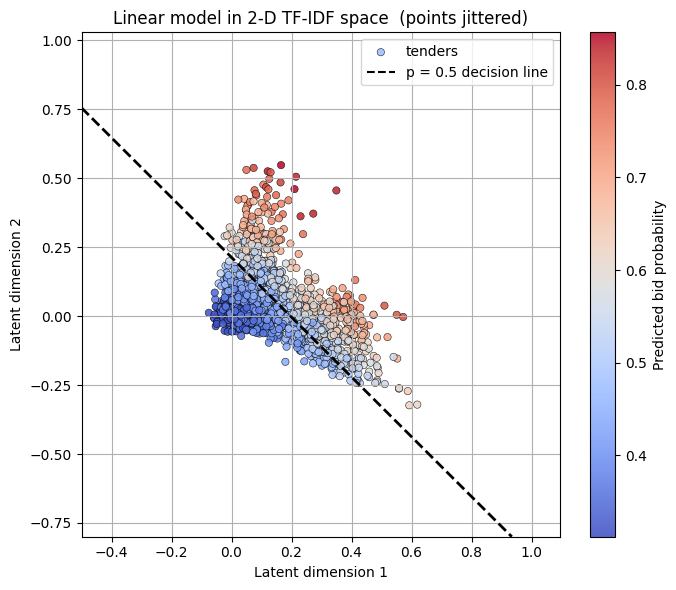

In [30]:
import matplotlib.pyplot as plt
import numpy as np
# ---- 0. small jitter so coincident points separate  ----------------
rng     = np.random.RandomState(42)
Z_jit   = Z + rng.normal(scale=0.03, size=Z.shape)   # 3 % of axis span

# ---- 1. probability grid for the contour line ---------------------
x_min, x_max = Z[:, 0].min() - .5, Z[:, 0].max() + .5
y_min, y_max = Z[:, 1].min() - .5, Z[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
proba_grid = clf2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
proba_grid = proba_grid.reshape(xx.shape)

# ---- 2. plot -------------------------------------------------------
plt.figure(figsize=(7, 6))

pts = plt.scatter(
        Z_jit[:, 0], Z_jit[:, 1],
        c = clf2d.predict_proba(Z)[:, 1],
        cmap = "coolwarm", s = 28,
        edgecolor = "k", linewidth = .4, alpha = .85,
        label = "tenders")

contour = plt.contour(
        xx, yy, proba_grid,
        levels = [0.5],                     # ½-probability
        colors = "k", linestyles = "--", linewidths = 2)

# add a legend entry for the contour
contour_proxy = plt.Line2D([], [], ls="--", color="k",
                           label="p = 0.5 decision line")
plt.legend(handles=[pts, contour_proxy])

plt.colorbar(pts, label="Predicted bid probability")
plt.xlabel("Latent dimension 1")
plt.ylabel("Latent dimension 2")
plt.title("Linear model in 2-D TF-IDF space  (points jittered)")
plt.grid(True)
plt.tight_layout()
plt.show()